In [ ]:
import tensorflow as tf
!pip install git+https://github.com/tensorflow/examples.git
from tensorflow_examples.models.pix2pix import pix2pix

import os
import time
import datetime
import pathlib
import matplotlib.pyplot as plt
from IPython.display import clear_output

AUTOTUNE = tf.data.AUTOTUNE

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-23hylxu2
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/examples.git /tmp/pip-req-build-23hylxu2
  Resolved https://github.com/tensorflow/examples.git to commit 0bbf4fe43fbf41b7174b9ce4a64d69bd33aadd21
  Preparing metadata (setup.py) ... done


In [ ]:
PATH = pathlib.Path('/content/drive/MyDrive/data')
list(PATH.parent.iterdir())

train_sketches = tf.data.Dataset.list_files(str(PATH / 'train/sketches/*.jpg'))
train_photos = tf.data.Dataset.list_files(str(PATH / 'train/photos/*.jpg'))

test_sketches = tf.data.Dataset.list_files(str(PATH / 'test/sketches/*.jpg'))
test_photos = tf.data.Dataset.list_files(str(PATH / 'test/photos/*.jpg'))

In [ ]:
BUFFER_SIZE = 404
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [ ]:
def load(file_name):
  image = tf.io.read_file(file_name)
  image = tf.io.decode_jpeg(image, 3)
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, [256,256], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  return image


In [ ]:
def random_crop(image):
  cropped_image = tf.image.random_crop(
      image, size=[IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image

In [ ]:
# normalizing the images to [-1, 1]
def normalize(image):
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  return image

In [ ]:
def random_jitter(image):
  # resizing to 286 x 286 x 3
  image = tf.image.resize(image, [286, 286],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  # randomly cropping to 256 x 256 x 3
  image = random_crop(image)

  # random mirroring
  image = tf.image.random_flip_left_right(image)

  return image


In [ ]:
def preprocess_image_train(image):
  image = load(image)
  image = random_jitter(image)
  image = normalize(image)
  return image

In [ ]:
def preprocess_image_test(image):
  image = load(image)
  image = normalize(image)
  return image

In [ ]:
train_sketches = train_sketches.cache().map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

train_photos = train_photos.cache().map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

test_sketches = test_sketches.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

test_photos = test_photos.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
sample_sketch = next(iter(train_sketches))
sample_photo = next(iter(train_photos))



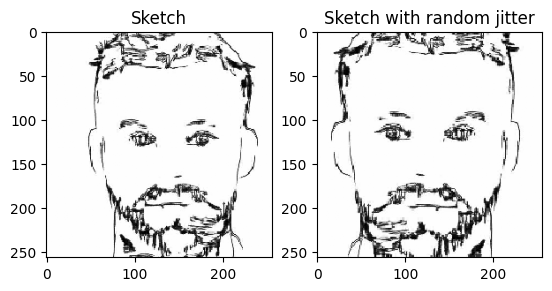

In [ ]:
plt.subplot(121)
plt.title('Sketch')
plt.imshow(sample_sketch[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Sketch with random jitter')
plt.imshow(random_jitter(sample_sketch[0]) * 0.5 + 0.5)


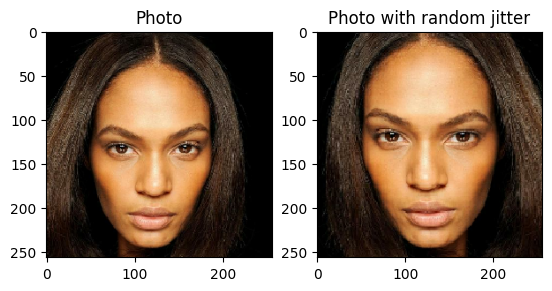

In [ ]:
plt.subplot(121)
plt.title('Photo')
plt.imshow(sample_photo[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Photo with random jitter')
plt.imshow(random_jitter(sample_photo[0]) * 0.5 + 0.5)


In [ ]:
OUTPUT_CHANNELS = 3
print(sample_sketch.shape)

(1, 256, 256, 3)


In [ ]:
generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)

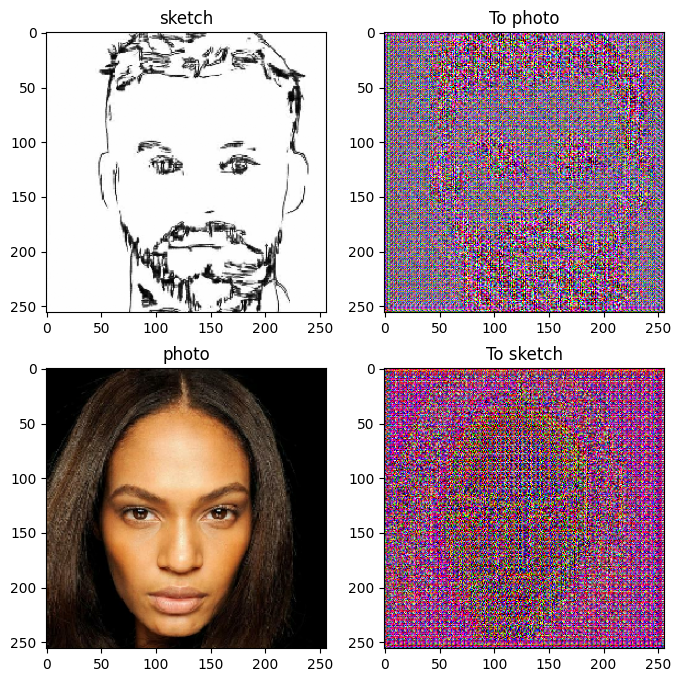

In [ ]:
to_photo = generator_g(sample_sketch)
to_sketch = generator_f(sample_photo)
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [sample_sketch, to_photo, sample_photo, to_sketch]
title = ['sketch', 'To photo', 'photo', 'To sketch']

for i in range(len(imgs)):
  plt.subplot(2, 2, i+1)
  plt.title(title[i])
  if i % 2 == 0:
    plt.imshow(imgs[i][0] * 0.5 + 0.5)
  else:
    plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)
plt.show()


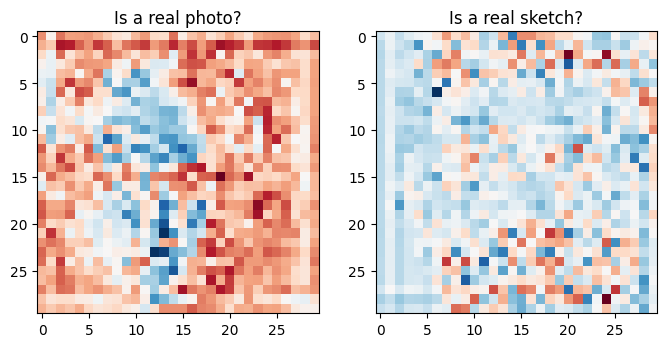

In [ ]:
plt.figure(figsize=(8, 8))

plt.subplot(121)
plt.title('Is a real photo?')
plt.imshow(discriminator_y(sample_photo)[0, ..., -1], cmap='RdBu_r')

plt.subplot(122)
plt.title('Is a real sketch?')
plt.imshow(discriminator_x(sample_sketch)[0, ..., -1], cmap='RdBu_r')

plt.show()

In [ ]:
LAMBDA = 10

In [ ]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)

  generated_loss = loss_obj(tf.zeros_like(generated), generated)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss * 0.5

In [ ]:
def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

In [ ]:
def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

  return LAMBDA * loss1

In [ ]:
def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss


In [ ]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [ ]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

In [ ]:
EPOCHS = 20

In [ ]:
def generate_images(model, test_input):
  prediction = model(test_input)

  plt.figure(figsize=(12, 12))

  display_list = [test_input[0], prediction[0]]
  title = ['Input Image', 'Predicted Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

In [ ]:
gen_g_losses = []
gen_f_losses = []
total_gen_g_losses = []
total_gen_f_losses = []
disc_x_losses = []
disc_y_losses = []
total_cycle_losses = []

In [ ]:
@tf.function
def train_step(real_x, real_y):
  # persistent is set to True because the tape is used more than
  # once to calculate the gradients.
  with tf.GradientTape(persistent=True) as tape:
    # Generator G translates X -> Y
    # Generator F translates Y -> X.

    fake_y = generator_g(real_x, training=True)
    cycled_x = generator_f(fake_y, training=True)

    fake_x = generator_f(real_y, training=True)
    cycled_y = generator_g(fake_x, training=True)

    # same_x and same_y are used for identity loss.
    same_x = generator_f(real_x, training=True)
    same_y = generator_g(real_y, training=True)

    disc_real_x = discriminator_x(real_x, training=True)
    disc_real_y = discriminator_y(real_y, training=True)

    disc_fake_x = discriminator_x(fake_x, training=True)
    disc_fake_y = discriminator_y(fake_y, training=True)

    # calculate the loss
    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)

    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)

    # Total generator loss = adversarial loss + cycle loss
    total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
    total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

    gen_g_losses.append(gen_g_loss)
    gen_f_losses.append(gen_f_loss)
    total_gen_g_losses.append(total_gen_g_loss)
    total_gen_f_losses.append(total_gen_f_loss)
    disc_x_losses.append(disc_x_loss)
    disc_y_losses.append(disc_y_loss)
    total_cycle_losses.append(total_cycle_loss)

  # Calculate the gradients for generator and discriminator
  generator_g_gradients = tape.gradient(total_gen_g_loss,
                                        generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_f_loss,
                                        generator_f.trainable_variables)

  discriminator_x_gradients = tape.gradient(disc_x_loss,
                                            discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss,
                                            discriminator_y.trainable_variables)

  # Apply the gradients to the optimizer
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients,
                                            generator_g.trainable_variables))

  generator_f_optimizer.apply_gradients(zip(generator_f_gradients,
                                            generator_f.trainable_variables))

  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))

  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))


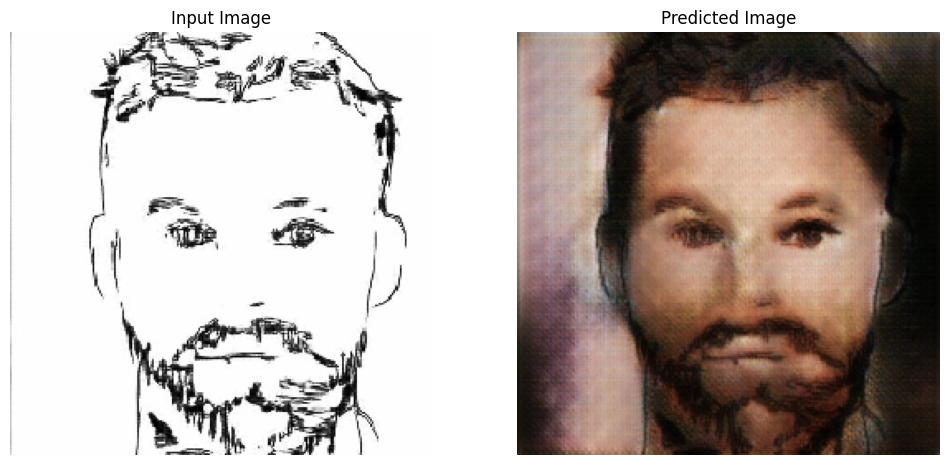

Saving checkpoint for epoch 10 at ./checkpoints/train/ckpt-4
Time taken for epoch 10 is 80.06463384628296 sec



In [ ]:
for epoch in range(EPOCHS):
  start = time.time()

  n = 0
  for image_x, image_y in tf.data.Dataset.zip((train_sketches, train_photos)):
    train_step(image_x, image_y)
    if n % 10 == 0:
      print ('.', end='')
    n += 1

  clear_output(wait=True)
  # Using a consistent image (sample_horse) so that the progress of the model
  # is clearly visible.
  generate_images(generator_g, sample_sketch)

  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))

  print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                      time.time()-start))


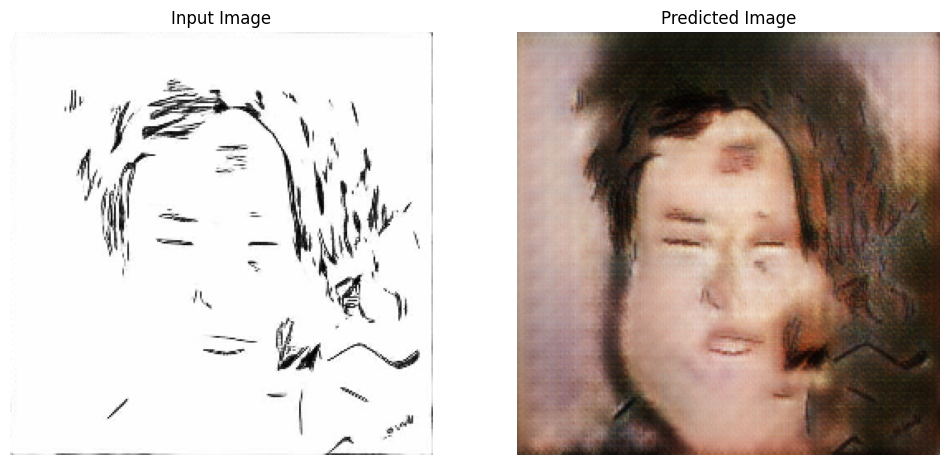

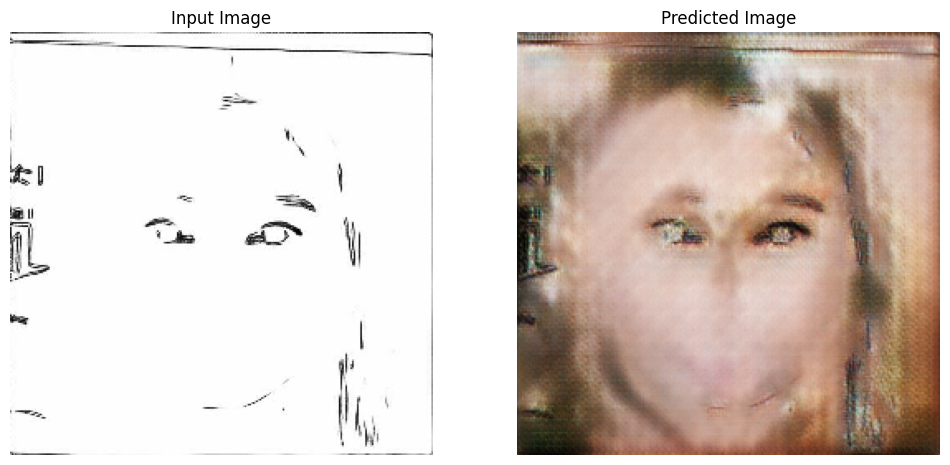

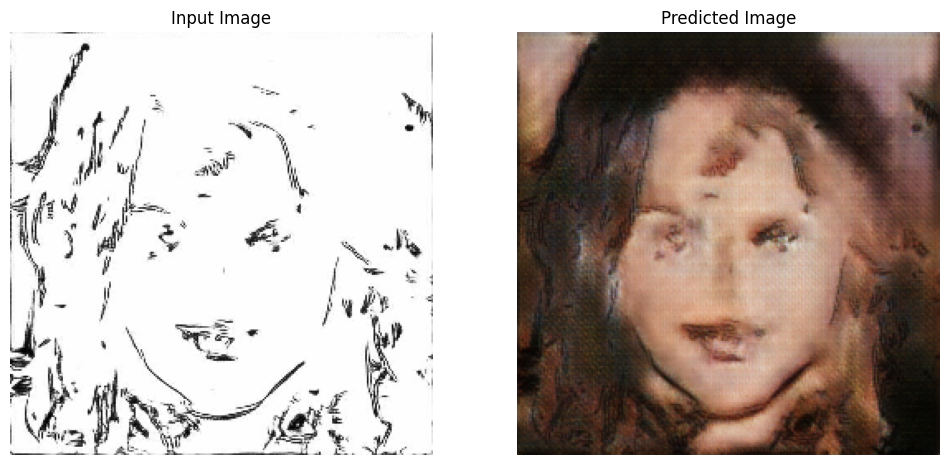

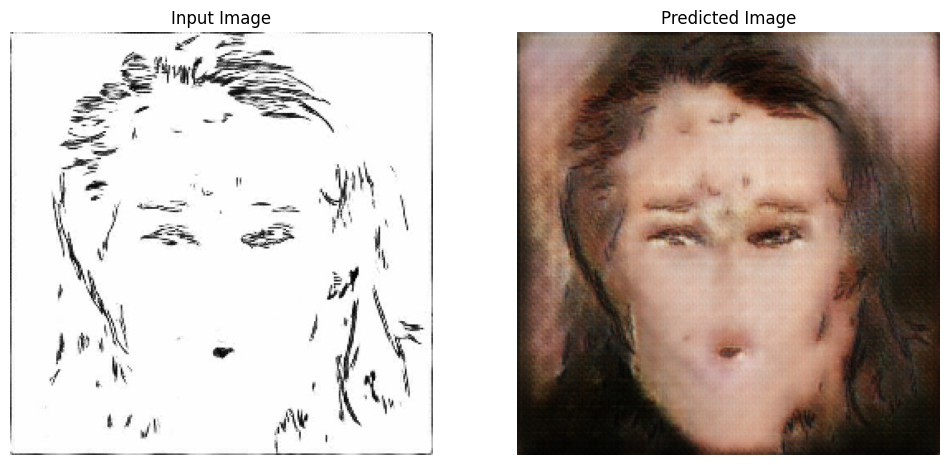

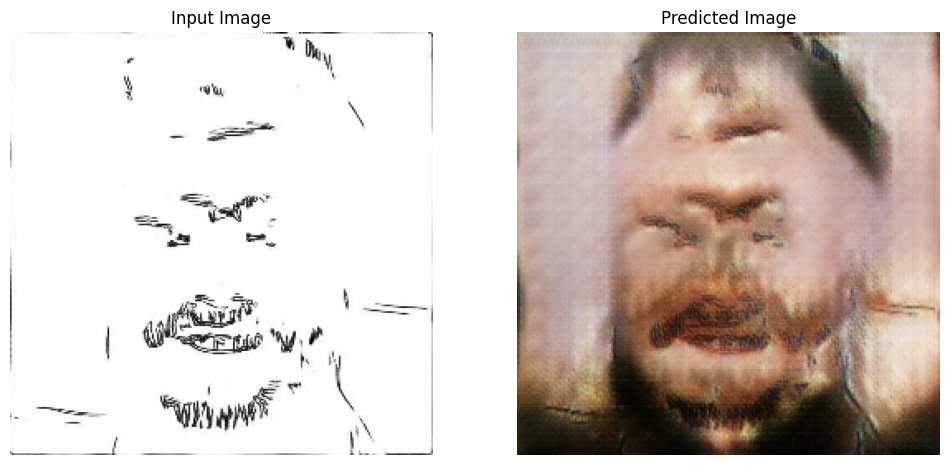

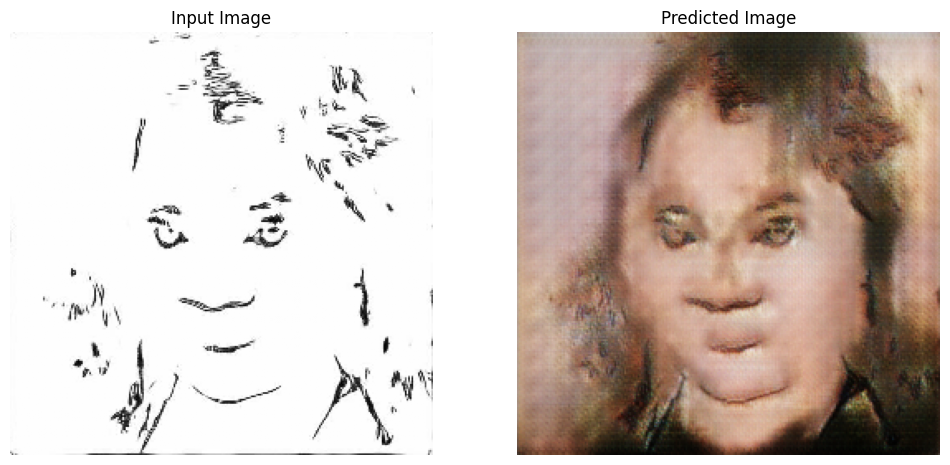

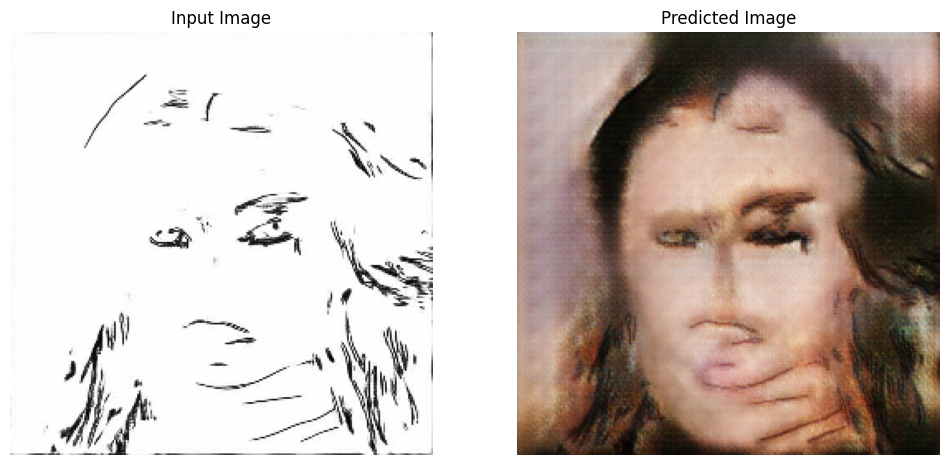

In [ ]:
# Run the trained model on the test dataset
for inp in test_sketches.take(7):
  generate_images(generator_g, inp)

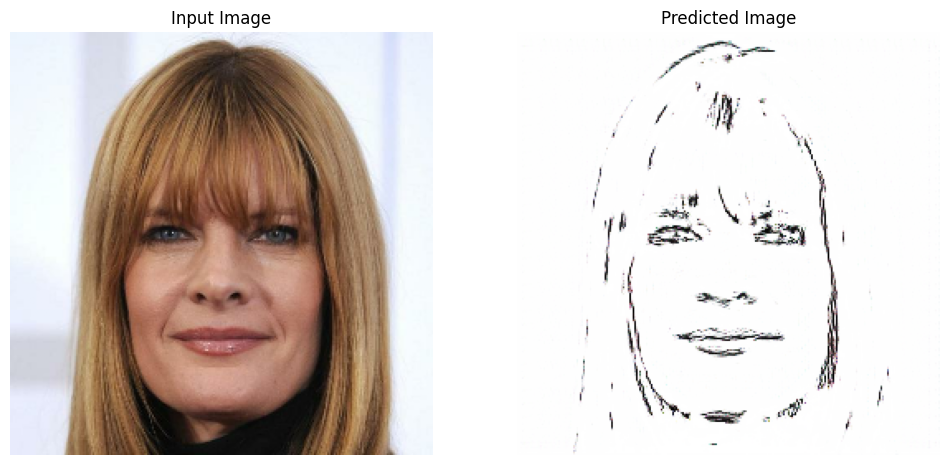

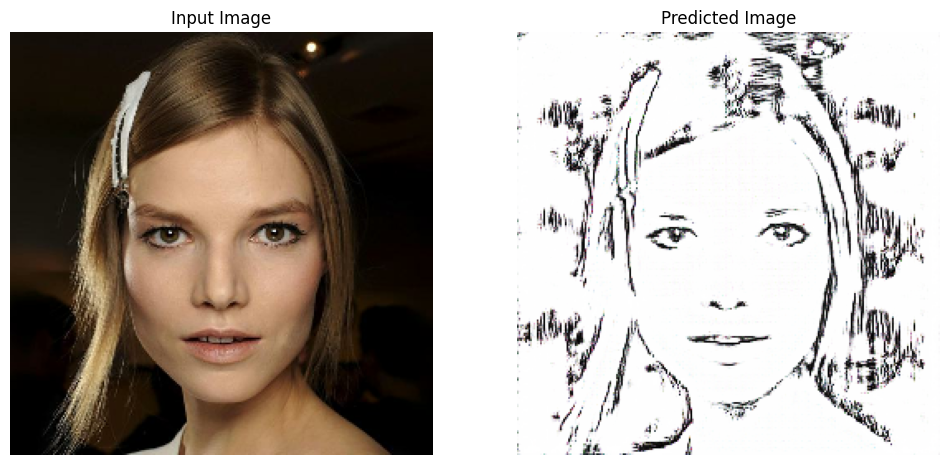

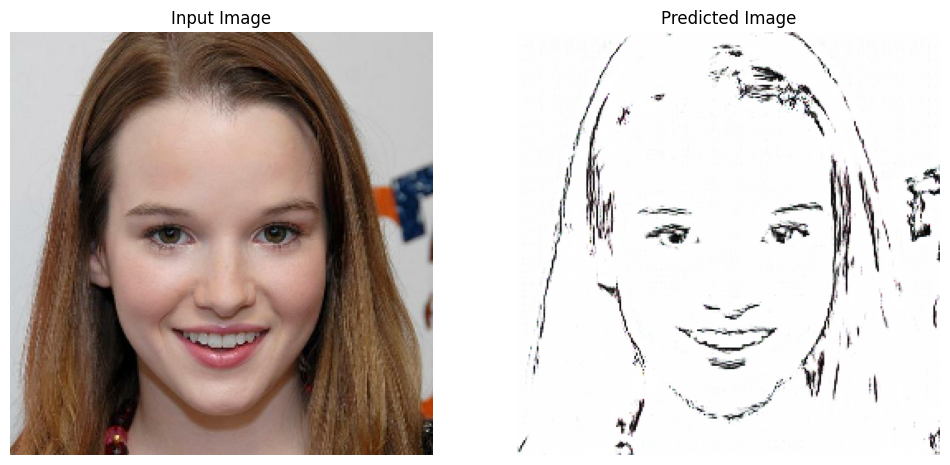

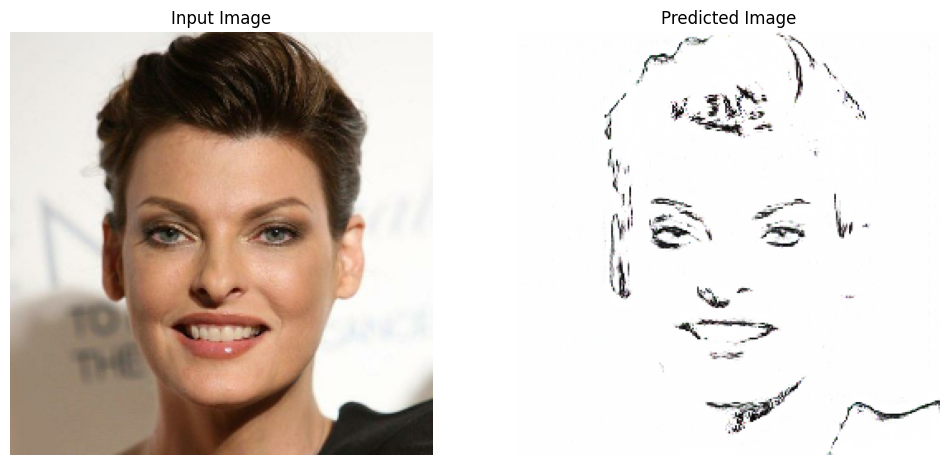

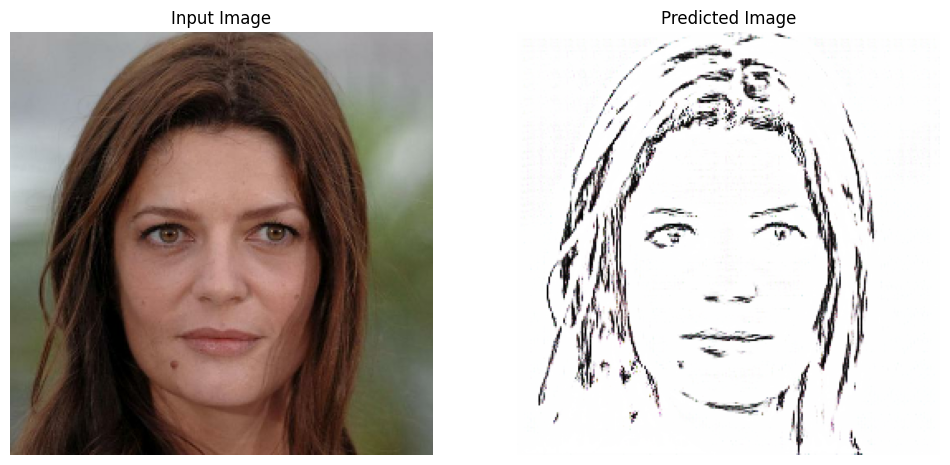

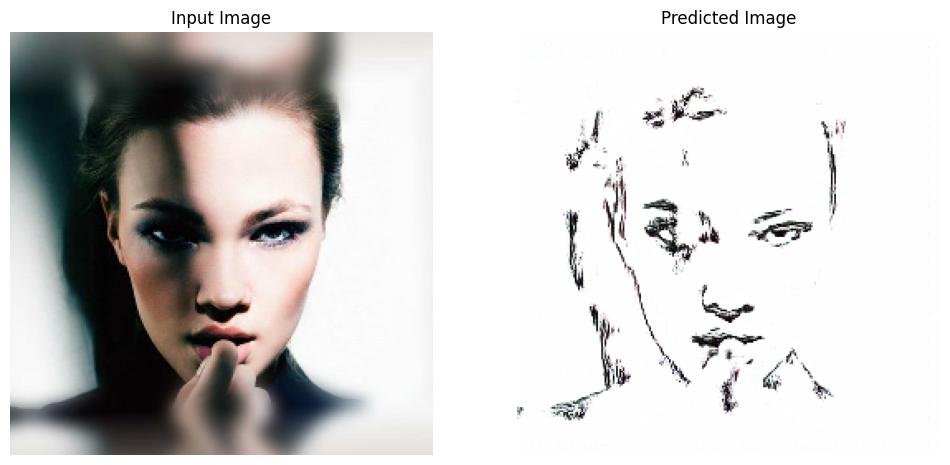

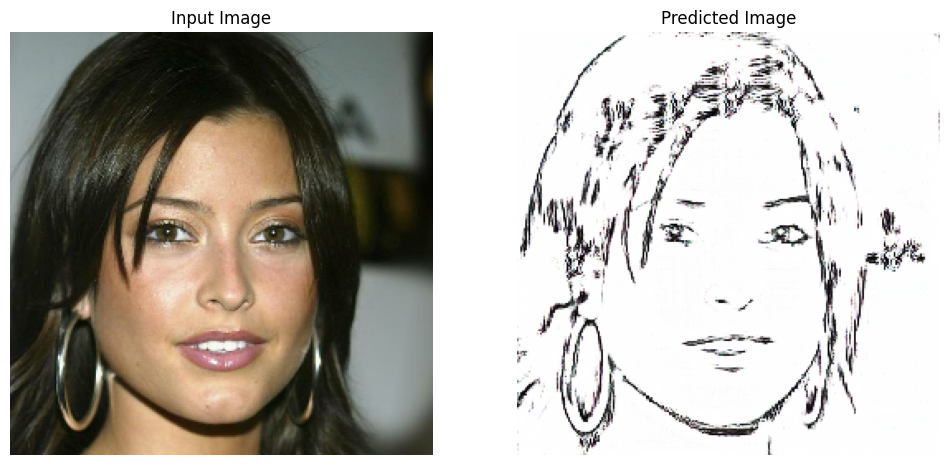

In [ ]:
for inp in test_photos.take(7):
  generate_images(generator_f, inp)

In [ ]:
def save_tests(model, image, name):
  prediction = model(image)
  plt.figure()
  display = prediction[0]
  plt.imshow(display * 0.5 + 0.5)
  plt.axis('off')
  plt.savefig('tests/{}.jpg'.format(name), bbox_inches='tight')
  plt.close()

  plt.figure()
  display = image[0]
  plt.imshow(display * 0.5 + 0.5)
  plt.axis('off')
  plt.savefig('samples/{}.jpg'.format(name), bbox_inches='tight')
  plt.close()


In [ ]:
x = 0
for inp in test_sketches:
  save_tests(generator_g, inp, x)
  x += 1

In [ ]:
def save_labels(model, image, name):
  plt.figure()
  display = image[0]
  plt.imshow(display * 0.5 + 0.5)
  plt.axis('off')
  plt.savefig('labels/{}.jpg'.format(name), bbox_inches='tight')
  plt.close()

In [ ]:
x = 0
for inp in test_photos:
  save_labels(generator_g, inp, x)
  x += 1

In [ ]:
# Get FID Score
!python fid.py /content/labels /content/tests

2023-08-09 04:34:27.306530: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-08-09 04:34:37.209129: W tensorflow/core/framework/op_def_util.cc:369] Op BatchNormWithGlobalNormalization is deprecated. It will cease to work in GraphDef version 9. Use tf.nn.batch_normalization().
2023-08-09 04:34:37.457170: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
/content/fid.py:297: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = np.array([imread(str(fn)).astype(np.float32) for fn in files])
2023-08-09 04:34:38.177057: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 90792600 exceeds 10% of free system memory.
2023-08-09 04:34:4